# Dataset

We are doing our analysis on [Spotify Multi-Genre Playlist Data](https://www.kaggle.com/siropo/spotify-multigenre-playlists-data).
This dataset is a collection of song features taken from Spotify and separated into six broad genres of music. 
Our analysis aims to answer to solve two problems:
1. How do you predict the genre of a song based on its features
2. What song features are more influential to a particular genre. 

It is not a random sampling of songs on Spotify: each song was on a playlist made by the person who collected the dataset. 
However, there is still a wide variety of genres it will work for purposes of our analysis. 
 
The dataset has the following 22 columns:

1. Artist Name
2. Song Name
3. Popularity: value from 1 to 100 that represents the song's popularity (magically determined by Spotify)
4. Genres: a detailed list of the genres for each artist
5. Playlist: the name of the playlist each song came from
6. Danceability
7. Energy
8. Key
9. Loudness
9. Mode
10. Speechiness
11. Acousticness
12. Instrumentalness
13. Liveness
14. Valence
15. Tempo
16. ID
17. URI
18. HRef
19. Analysis_url
19. Duration_Ms
20. Time-Signature

## Loading the dataset

The dataset is broken into 6 files, with each file containing the songs from a single genre of music. 
Here, we load the files into memory and combine them into one dataset. 
We also drop the playlist, ID, URI, HRef, and Analysis_url columns because they are not relevant for our analysis. 
Since we will be combining all of the songs into a single dataset, we also have to add another column containing the genre of each song. 

In [1]:
import pandas as pd

def load_dataset(music_genre):
    # First, we read the genre dataset into memory
    # Then we drop all of the columns we don't need
    # and finally we add the genre column and return it 
    return pd.read_csv(f'{music_genre}_music_data.csv').drop(columns=['Playlist', 'id', 'uri', 'track_href', 'analysis_url']).assign(genre=music_genre)

alternative = load_dataset('alternative')
blues = load_dataset('blues')
hiphop = load_dataset('hiphop')
indie_alt = load_dataset('indie_alt')
metal = load_dataset('metal')
pop = load_dataset('pop')
rock = load_dataset('rock')
    
dataset = pd.concat([alternative, blues, hiphop, indie_alt, metal, pop, rock])

# Analysis

## Logistic Regression

In the last logistic regression analysis, we determined variables are the least significant for identifying each genre. 
In this analysis, we will use forward variable selection to determine which variables are the most significant for distinguishing each genre. 

In [2]:
import statsmodels.api as sm
import math

def make_genre_training_data(genre_name):# collect all of the songs that belong to the given genre (and ignore any columns that aren't song features)
    X_same_genre = dataset[dataset['genre'] == genre_name].loc[:, 'danceability':'duration_ms']
    # Collect the songs that don't belong to the given genre (collect only a random sample to ensure a balanced dataset)
    X_different_genre = dataset[dataset['genre'] != genre_name].loc[:,'danceability':'duration_ms'].sample(n=len(X_same_genre))
    
    X_train = pd.concat([X_same_genre, X_different_genre], ignore_index=True)
    
    # for the Y data, we just need to make a dataframe of all 1s or all 0s with the same length as the X data
    Y_same_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=1)
    Y_different_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=0)

    Y_train = pd.concat([Y_same_genre,Y_different_genre], ignore_index=True)
    
    return X_train, Y_train

This function finds the most influential variable by building a separate logistic model for each feature and selecting the one with the lowest AIC score.
By default, it just returns the name of the most influential variable.
If you want to find the 2nd, 3rd, 4th, etc most influential variable, you can manually add variables to the logistic regression by using the fixed_vars parameter.
For example, if I want to find the 2nd most influential variable for distinguishing metal music, and I know that the most influential variable is energy, then I would use: `find_best_variable('metal', ['energy'])`
Also, you can change how verbose the function is. 
If the verbosity is set to a value greater than 0, it will also show the AIC score for each feature.

In [3]:
def find_best_variable(genre_name, default_cols=None, verbose=0):
    if default_cols is None:
	    default_cols = []
        
    X_train_all_cols, Y_train = make_genre_training_data(genre_name)
    
    lowest_aic = math.inf
    best_variable = ''
    
    if verbose > 0:
        print(f'{genre_name}:')
    
    # loop through all columns (ignoring the ones that are already added to the logistic model)
    for col in X_train_all_cols.drop(columns=default_cols):
        # Creates list of the cols and the training data we'll be using to train the logistic model
        training_cols = [col]
        training_cols.extend(default_cols)
        X_train = X_train_all_cols.loc[:,training_cols]

        logistic_model = sm.Logit(Y_train, X_train).fit(disp=0)
    
        if logistic_model.aic < lowest_aic:
            lowest_aic = logistic_model.aic
            best_variable = col
        
        if verbose > 0:
            print('  Variable:', col,'\t| aic:', logistic_model.aic)
        
    return best_variable

Here, we find the most influential variable for distinguishing each genre, as determined by forward variable selection.

In [4]:
# Uncomment this to see the AIC score for every metal logistic model
# find_best_variable('metal', verbose=1)
print('Best Variable for Alternative:', find_best_variable('alternative'))
print('Best Variable for Blues:', find_best_variable('blues'))
print('Best Variable for Hip Hop:', find_best_variable('hiphop'))
print('Best Variable for Indie Alt:', find_best_variable('indie_alt'))
print('Best Variable for Metal:', find_best_variable('metal'))
print('Best Variable for Pop:', find_best_variable('pop'))
print('Best Variable for Rock:', find_best_variable('rock'))

Best Variable for Alternative: instrumentalness
Best Variable for Blues: acousticness
Best Variable for Hip Hop: speechiness
Best Variable for Indie Alt: instrumentalness
Best Variable for Metal: acousticness
Best Variable for Pop: instrumentalness
Best Variable for Rock: speechiness


The results are somewhat surprising... [TODO: add analysis]

In this section, we continue our forward variable selection to find the second most influential variable.

In [5]:
find_best_variable('metal', default_cols=['acousticness'], verbose=1)
# TODO: add finish this.

metal:
  Variable: danceability 	| aic: 7433.635302947552
  Variable: energy 	| aic: 7011.268163945824
  Variable: key 	| aic: 7277.971555354989
  Variable: loudness 	| aic: 7263.477533967697
  Variable: mode 	| aic: 7363.368005559951
  Variable: speechiness 	| aic: 7278.813421574714
  Variable: instrumentalness 	| aic: 7080.335145208228
  Variable: liveness 	| aic: 7207.874765929412
  Variable: valence 	| aic: 7462.610087577701
  Variable: tempo 	| aic: 7154.918559173062
  Variable: duration_ms 	| aic: 6963.655467896603


'duration_ms'

## Clustering

In [10]:
## Prepping Data for Clustering
# random sample 2k entries from each of the datasets


alt_rds = alternative.sample(n=2000, random_state=1)
blu_rds = blues.sample(n=2000, random_state=1)
hip_rds = hiphop.sample(n=2000, random_state=1)
ind_rds = indie_alt.sample(n=2000, random_state=1)
met_rds = metal.sample(n=2000, random_state=1)
pop_rds = pop.sample(n=2000, random_state=1)
roc_rds = rock.sample(n=2000, random_state=1)
rds = pd.concat([alt_rds, blu_rds, hip_rds, ind_rds, met_rds, pop_rds, roc_rds])
print(rds.shape)

(14000, 18)


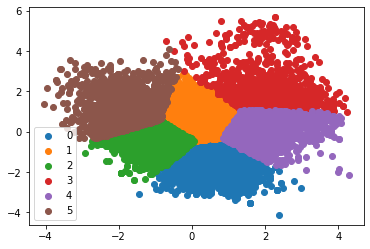

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df1 = rds[['Track Name','danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
clustering_df = df1.loc[:, df1.columns != 'Track Name']
scaler = StandardScaler()
X_std = scaler.fit_transform(clustering_df)

pca = PCA(2)
df = pca.fit_transform(X_std) 
 
kmeans = KMeans(n_clusters= 6)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
clustering_df.insert(8, 'Cluster', label, True)

#Getting unique labels
u_labels = np.unique(label)

#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [14]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

cluster_mean = clustering_df.groupby(['Cluster']).mean()

x = cluster_mean.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_mean = pd.DataFrame(x_scaled)

categories = ['danceability','energy','speechiness','acousticness', 'instrumentalness','liveness','valence','tempo']

fig = go.Figure()

for index, row in cluster_mean.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row,
      theta=categories,
      fill='toself',
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()
#fig.write_image("radar.png")